# A demo of perceptron learning

In this notebook, we will code up the perceptron learning algorithm and see it in action on two learning tasks. The first is a rather contrived situation in which we have randomly-generated linearly-separable data in two dimensions. But in this setting, we can see the motion of the decision plane as the algorithm progresses. In the second task, we train a perceptron to distinguish between images of handwritten numbers.

The only requirements for running this notebook are in the next cell: `numpy` and `matplotlib`.

In [408]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

%matplotlib inline

## The algorithm

The perceptron algorithm used is the same as in the course notes, except that it takes an optional `callback` function that is run at the end of each iteration. This will allow us to do things like plot the decision surface as the algorithm learns.

In [412]:
def train_perceptron(features, labels, max_iter=100, callback=None, step_size=1):
    """Trains a perceptron.
    
    Parameters
    ----------
    data
        An (n x d) numpy array of d-dimensional training vectors.
    labels
        A d-dimensional numpy array of labels (+1 or -1)
    step_size
        The step size. If it is callable, it is called at every iteration.
        The result is used as the step size.
    
    Returns
    -------
    w
        A d-dimensional weight vector describing the decision hyperplane.
    
    """
    n, d = features.shape
    w = np.zeros(d)

    for i in range(max_iter):
        # find all of the examples which are misclassified
        predictions = features @ w
        misclassified_lix = np.sign(predictions) != labels
        misclassified_examples = features[misclassified_lix]
        misclassified_labels = labels[misclassified_lix]
        
        if len(misclassified_examples) == 0:
            break
            
        if callable(step_size):
            alpha = step_size(i)
        else:
            alpha = step_size

        correction = alpha * np.sum(
                misclassified_examples 
                * 
                misclassified_labels[:,np.newaxis],
            axis=0
        )
        w = w + correction
        
        if callback is not None:
            callback(w)
        
    return w

## Demo 1: Visualizing the decision boundary

In this example, we will randomly generate data from a uniform distribution on a square and assign each point to one of two classes in a linearly-separable way.

First, we generate some data.

In [427]:
# the number of examples
n = 100

# the margin between the classes. the bigger this number, the easier the classification.
# but if the number is too small, training might take a long time to converge!
margin = .01

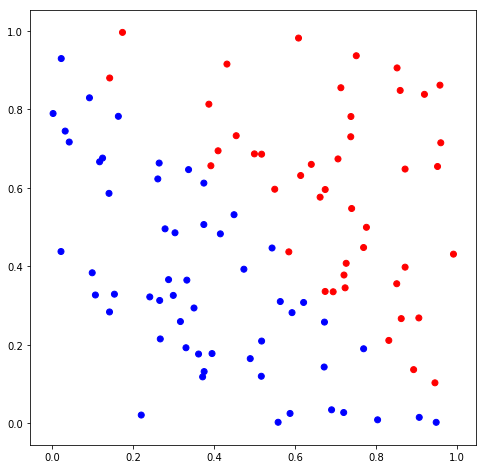

In [429]:
# generate n training examples from uniform distribution on square
features = np.random.uniform(size=(n,2))

# append a dummy 1 to each feature vector
features = np.column_stack((features, np.ones(n)))

# remove those points which are very close to the true decision plane
close_lix = (np.abs(features[:,0] + features[:,1] - 1)) < margin
features = features[~close_lix]

# assign a label of either 1 or -1 to each data point in such a way
# that the classes are linearly-separable
labels = np.where(features[:,0] + features[:,1] < 1, -1, 1)

# pick a color for each point according to its label
# red if class 1, blue if class -1
colors = ['red' if label == 1 else 'blue' for label in labels]

# plot the data
plt.figure(figsize=(8,8))
plt.scatter(*features[:,:2].T, c=colors)

The data are linearly-separable, so the perceptron learning algorithm should be able to achieve zero training error.

In [447]:
w_history = []
def save_parameters(w):
    w_history.append(w)
    
def step_size(i):
    return 1/(i + 1)

w = train_perceptron(features, labels, callback=save_parameters, step_size=step_size)
w

array([ 14.58712496,  13.50117804, -13.95116772])

The list `w_history` now contains a history of $w$ as the algorithm learned.

In [448]:
len(w_history)

68

Let's visualize the progress of $w$ by animating it.

In [449]:
%%capture
fig = plt.figure(figsize=(8,8))
ax = plt.gca()

features_pos = features[labels == 1]
features_neg = features[labels == -1]

scatter_pos = ax.scatter(*features_pos[:,:2].T, c='purple', marker='+', s=75)
scatter_neg = ax.scatter(*features_neg[:,:2].T, c='green', marker='_', s=75)

[line] = ax.plot([], [], color='black')
line.set_data([], [])

def decision_boundary(w):
    def y(x):
        return (-w[0] * x - w[2])/w[1]
    x = np.array([0, 1])
    return x, y(x)

def animate(t):
    x, y = decision_boundary(w_history[t])
    line.set_data(x, y)
    
    w = w_history[t]
    predictions_pos = np.sign(features_pos @ w)
    predictions_neg = np.sign(features_neg @ w)
    
    colors_pos = np.where(predictions_pos == 1, 'purple', 'red')
    scatter_pos.set_color(colors_pos)
    
    colors_neg = np.where(predictions_neg == -1, 'green', 'red')
    scatter_neg.set_color(colors_neg)
    
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(w_history))

The next cell might take a little time to run, because Matplotlib isn't fast at animating...

Once the animation runs, you'll see that some points are red. These are the points which have been misclassified by the decision boundary.

In [450]:
HTML(ani.to_jshtml())

Try changing the step size. If it is too big, the decision plane will bounce around and take a long time to converge. A good approach is to make the step size a decaying function of the iteration number, but if it decays too quickly the algorithm might not converge!

## Demo 2: Recognizing digits

In this demo, we will teach the computer to distinguish between handwritten digits. Our data is the popular MNIST data set.

In [452]:
mnist = np.load('mnist.npz')

At first we will try to learn the difference between 3's and 8's. Later we can come back and change this cell to try and classify other digits.

In [454]:
class_1 = 3
class_2 = 8

We will separate the data into two groups: the training data and the test data. The perceptron algorithm will only see the training data while it is learning. We will then show the test data to the learned perception and test its performance.

In [456]:
def preprocess_features(images):
    n = len(images)
    features = images.reshape(n, -1)
    features = np.column_stack((features, np.ones(n)))
    return features

def translate_labels(labels):
    return np.where(labels == class_1, 1, -1)

train_ix = (mnist['y_train'] == class_2) | (mnist['y_train'] == class_1)
test_ix = (mnist['y_test'] == class_2) | (mnist['y_test'] == class_1)

train_images = mnist['x_train'][train_ix]
train_features = preprocess_features(train_images)
train_labels = translate_labels(mnist['y_train'][train_ix])

test_images = mnist['x_test'][test_ix]
test_features = preprocess_features(test_images)
test_labels = translate_labels(mnist['y_test'][test_ix])

Here is what an image looks like:

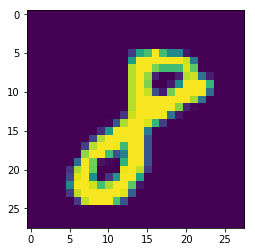

In [457]:
plt.imshow(train_images[6])

Now we train the perceptron.

In [487]:
w_history = []
w = train_perceptron(train_features, train_labels, max_iter=300, callback=save_parameters)

Again we have stored the decision boundary at every iteration of the learning algorithm. However, now $w$ is not a vector in 2 dimensions, but rather a vector in 785 dimensions. But we can still visualize it -- its first 784 components can be reshaped into a 28 x 28 image and pictured.

In [459]:
%%capture

fig = plt.figure(figsize=(8,8))
ax = plt.gca()

def animate(t):
    ax.imshow(w_history[t*2][:784].reshape(28, -1), vmin=-1e6, vmax=1e6)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=50)

In [460]:
# this might take a while...
HTML(ani.to_jshtml())

The above animation shows the weights learned by the perceptron as the algorithm proceeds. Bright yellow regions are large and positive, while dark purple regions are large negative. Here, the negative class is an 8. Therefore, a perceptron looks to the dark purple regions to determine if a digit is an 8, and to the bright yellow to determine if it is a 3.

Below we calculate the error of the perceptron on both the training and test set. It seems to perform OK on both.

In [488]:
# train error
train_predictions = np.sign(train_features @ w)
np.sum(train_predictions == train_labels) / len(train_labels)

0.9479218828242364

In [489]:
# test error
test_predictions = np.sign(test_features @ w)
np.sum(test_predictions == test_labels) / len(test_labels)

0.9369959677419355

We can visualize the examples that the algorithm got wrong:

In [490]:
indices_of_incorrect = np.nonzero(test_predictions != test_labels)
indices_of_incorrect

(array([  25,   34,   78,   84,   87,   97,  109,  111,  133,  160,  161,
         170,  201,  216,  222,  232,  239,  253,  261,  273,  300,  329,
         357,  371,  376,  377,  380,  410,  424,  434,  443,  448,  454,
         465,  479,  480,  486,  506,  508,  523,  594,  599,  631,  645,
         651,  654,  659,  664,  665,  677,  694,  707,  719,  728,  731,
         737,  745,  750,  752,  761,  765,  781,  783,  800,  801,  802,
         816,  818,  822,  824,  825,  868,  890,  915,  916,  921,  926,
         929,  936,  949,  956,  959,  970,  983,  987, 1001, 1007, 1012,
        1084, 1085, 1094, 1132, 1172, 1175, 1176, 1179, 1180, 1187, 1188,
        1194, 1195, 1243, 1298, 1308, 1338, 1351, 1411, 1428, 1432, 1442,
        1461, 1496, 1506, 1525, 1554, 1636, 1643, 1644, 1648, 1703, 1803,
        1807, 1848, 1965, 1973]),)

In [491]:
def predict(t):
    image = test_images[t]
    feature = test_features[t]
    prediction = class_2 if np.sign(w @ feature) == -1 else class_1
    plt.imshow(image)
    
    print(f'I predict that this is a {prediction}!')

I predict that this is a 3!


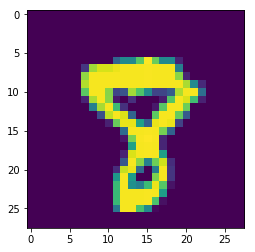

In [492]:
predict(34)

We have run the algorithm for only 300 iterations. It is possible that we can do better by running it longer. Try changing the 300 to 1000. What if we really upped the number of iterations -- would it ever converge? Is the test error guaranteed to get better?